In [3]:
import os
import math
import numpy as np
import copy as cp
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt

## Import KITTI GT

#### import intrinsic matrix

In [14]:
calib_path = '../../intermediate-data/kitti-baselines/calib/'

#### function to get the calibration matrix in order to transform from 2D pixel space to 3D distance space

In [5]:
def get_calibration(path_txt):
    """Read calibration parameters from txt file:
    For the left color camera we use P2 which is K * [I|t]

    P = [fu, 0, x0, fu*t1-x0*t3
         0, fv, y0, fv*t2-y0*t3
         0, 0,  1,          t3]

    check also http://ksimek.github.io/2013/08/13/intrinsic/

    Simple case test:
    xyz = np.array([2, 3, 30, 1]).reshape(4, 1)
    xyz_2 = xyz[0:-1] + tt
    uv_temp = np.dot(kk, xyz_2)
    uv_1 = uv_temp / uv_temp[-1]
    kk_1 = np.linalg.inv(kk)
    xyz_temp2 = np.dot(kk_1, uv_1)
    xyz_new_2 = xyz_temp2 * xyz_2[2]
    xyz_fin_2 = xyz_new_2 - tt
    """

    with open(path_txt, "r") as ff:
        file = ff.readlines()
    p2_str = file[2].split()[1:]
    p2_list = [float(xx) for xx in p2_str]
    p2 = np.array(p2_list).reshape(3, 4)

    kk = p2[:, :-1]
    f_x = kk[0, 0]
    f_y = kk[1, 1]
    x0 = kk[2, 0]
    y0 = kk[2, 1]
    aa = p2[0, 3]
    bb = p2[1, 3]
    t3 = p2[2, 3]
    t1 = (aa - x0*t3) / f_x
    t2 = (bb - y0*t3) / f_y
    tt = np.array([t1, t2, t3]).reshape(3, 1)
    return kk, tt

#### load the validation image ids

In [9]:
val_labels=open("../../intermediate-data/kitti-baselines/val.txt", "r").read().split('\n')

#### load the names of the annotation files of kitti data set

In [10]:
labels_names=os.listdir('../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/training/label_2/')
labels_names.sort()

#### store and transform all the gt values for each pedestrian detection

In [21]:
gt = []
positions=[]
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/training/label_2/'+label) as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        for line in temp:
            if line[0]=='Pedestrian':
                
                pedestrian = {}
                
                pedestrian['image_id'] = label[:6]
                
                pedestrian['cam intrinsic'] = get_calibration(calib_path + pedestrian['image_id']+'.txt')[0]
                
                pedestrian['truncation'] = float(line[1])
                
                pedestrian['occlusion'] = int(line[2])
                
                pedestrian['obs_angle'] = float(line[3])*180/math.pi + 180
                
                #pedestrian['obs_angle'] = (pedestrian['obs_angle'] if pedestrian['obs_angle']<360 else pedestrian['obs_angle']-360)
                
                pedestrian['gt_bbox'] = [float(i) for i in line[4:8]]
                
                pedestrian['gt_dim'] = [float(i) for i in line[8:11]]
                
                pedestrian['gt_pos'] = [float(i) for i in line[11:14]]
                
                pedestrian['raw_orient'] = float(line[14])*180/math.pi
                
                pedestrian['abs_orient'] = float(line[14])*180/math.pi + 180 + 270
                
                pedestrian['abs_orient'] = (pedestrian['abs_orient'] if pedestrian['abs_orient']<360 else pedestrian['abs_orient']-360)
                
                pedestrian['r_angle'] = math.atan2(pedestrian['gt_pos'][0] , pedestrian['gt_pos'][2])*180/math.pi
                
                pedestrian['gt_orient'] = pedestrian['abs_orient'] - pedestrian['r_angle']
                
                pedestrian['gt_orient'] = (pedestrian['gt_orient'] if pedestrian['gt_orient']<360 else pedestrian['gt_orient']-360)
                
                pedestrian['gt_orient'] = (pedestrian['gt_orient'] if pedestrian['gt_orient']>0 else 360+pedestrian['gt_orient'])
                
                gt.append(pedestrian)
print('we have', len(gt),'ground truth pedestrians')

we have 2280 ground truth pedestrians


## Import 3dop

#### load 3dop output annoations

In [16]:
data_3dop = []
positions=[]
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('../../intermediate-data/kitti-baselines/3dop/'+label) as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        
        for line in temp:
            if line[0]=='pedestrian':
                
                pedestrian = {}
                
                pedestrian['image_id'] = label[:6]
                
                pedestrian['truncation'] = float(line[1])
                
                pedestrian['occlusion'] = int(line[2])
                
                pedestrian['obs_angle'] = float(line[3])*180/math.pi + 180
                
                #pedestrian['obs_angle'] = (pedestrian['obs_angle'] if pedestrian['obs_angle']<360 else pedestrian['obs_angle']-360)
                
                pedestrian['pred_bbox'] = [float(i) for i in line[4:8]]
                
                pedestrian['pred_dim'] = [float(i) for i in line[8:11]]
                
                pedestrian['pred_pos'] = [float(i) for i in line[11:14]]
                
                pedestrian['rawp_orient'] = float(line[14])*180/math.pi
                
                pedestrian['abs_orient'] = float(line[14])*180/math.pi + 180 + 270
                
                pedestrian['abs_orient'] = (pedestrian['abs_orient'] if pedestrian['abs_orient']<360 else pedestrian['abs_orient']-360)
                
                pedestrian['r_angle'] = math.atan2(pedestrian['pred_pos'][0] , pedestrian['pred_pos'][2])*180/math.pi
                
                pedestrian['pred_orient'] = pedestrian['abs_orient'] - pedestrian['r_angle']
                
                pedestrian['pred_orient'] = (pedestrian['pred_orient'] if pedestrian['pred_orient']>0 else 360+pedestrian['pred_orient'])
                
                data_3dop.append(pedestrian)
print('we have', len(data_3dop),'3dop pedestrians')

we have 4079 3dop pedestrians


#### we define the IOU functions to match the individuals

In [17]:
def get_inter_area(r1, r2):
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    if (top-bottom)<0 and (right-left)<0:
        return 0
    else:
        return (top-bottom)*(right-left)

def get_union_area(r1, r2):
    return (r1[2]-r1[0])*(r1[3]-r1[1]) + (r2[2]-r2[0])*(r2[3]-r2[1]) - get_inter_area(r1, r2)

def get_inter_matrix(pred_image, gt_image):
    inter_matrix=[]
    for gt in gt_image:
        inter_line=[]
        gt_box= gt['gt_bbox']
        for pred in pred_image:
            pred_box=pred['pred_bbox']
            inter_line.append(get_inter_area(gt_box,pred_box)/get_union_area(gt_box, pred_box))
        inter_matrix.append(inter_line)
    return np.array(inter_matrix)

In [18]:
def match_gt_pred(inter_matrix):
    max_val=np.max(inter_matrix)
    matches=[]
    while max_val>0.4:
        args_max=np.unravel_index(np.argmax(inter_matrix, axis=None), inter_matrix.shape)
        inter_matrix[args_max[0],:]=0
        inter_matrix[:,args_max[1]]=0
        matches.append(args_max)
        max_val=np.max(inter_matrix)
    return matches

#### match the 3dop and ground truth detections with a IOU over 0.4

In [22]:
%%time
matched_3dop_data=[]
for i, image_id in enumerate(labels_names):
    
    #update_progress(i/len(labels_names))
    gt_ann = list(filter(lambda d: d['image_id']==image_id[:6], gt))
    
    pred_ann = list(filter(lambda d: d['image_id']==image_id[:6], data_3dop))
    #print(i, len(gt_ann), len(pp_ann))
    matrix=get_inter_matrix(pred_ann, gt_ann)
    
    if matrix.size:
        matches = match_gt_pred(matrix)
        
        for (i,j) in matches:
            pedestrian=cp.deepcopy(gt_ann[i])
            pedestrian['pred_orient']=pred_ann[j]['pred_orient']
            pedestrian['pred_dim']=pred_ann[j]['pred_dim']
            pedestrian['pred_pos']=pred_ann[j]['pred_pos']
            pedestrian['pred_bbox']=pred_ann[j]['pred_bbox']
            pedestrian['rawp_orient']=pred_ann[j]['rawp_orient']

            matched_3dop_data.append(pedestrian)

CPU times: user 6.59 s, sys: 2.24 ms, total: 6.6 s
Wall time: 6.59 s


In [25]:
print('we have', len(matched_3dop_data),'3dop matches')

we have 1693 3dop matches


### Error calculations

In [15]:
errors_angle_3dop = []
errors_dim_3dop = []
errors_pos_3dop = []

for data in matched_3dop_data:
    error_angle = abs(data['gt_orient']-data['pred_orient'])
    error_angle = (error_angle if error_angle < 180 else 360-error_angle)
    errors_angle_3dop.append(error_angle)
    
    errors_dim_3dop.append(np.linalg.norm(np.array(data['gt_dim']) - np.array(data['pred_dim'])))
    errors_pos_3dop.append(np.linalg.norm(np.array(data['gt_pos']) - np.array(data['pred_pos'])))
    
    

#### The average error we get for angle in degrees, dimensions in m and position in m

In [16]:
np.mean(errors_angle_3dop), np.mean(errors_dim_3dop), np.mean(errors_pos_3dop)

(44.676874604170095, 0.49726996228735987, 1.0989678807169156)

#### we then proceed to separate instances between easy moderate and hard following the conditions from kitti benchmark

In [17]:
def get_category(pedestrian):
    
    box = pedestrian['gt_bbox']
    
    trunc = pedestrian['truncation']
    
    occ = pedestrian['occlusion']

    hh = box[3] - box[1]

    if hh >= 40 and trunc <= 0.15 and occ <= 0:
        cat = 'easy'
    elif trunc <= 0.3 and occ <= 1:
        cat = 'moderate'
    else:
        cat = 'hard'

    return cat

In [18]:
for data in matched_3dop_data:
    data['cat'] = get_category(data)

In [27]:
import pandas as pd
matched_3dop_df = pd.DataFrame(matched_3dop_data)

#### the following table summarises the errors for each predicted value

In [20]:
##  add orientation error
angle_loss = abs(matched_3dop_df['gt_orient']-matched_3dop_df['pred_orient'])
angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
matched_3dop_df['error_orient'] = angle_loss

##  add raw orientation error
angle_loss = abs(matched_3dop_df['raw_orient']-matched_3dop_df['rawp_orient'])
angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
matched_3dop_df['error_rorient'] = angle_loss

## add dim error
pred_dim = np.array(matched_3dop_df['pred_dim'].tolist())
og_dim = np.array(matched_3dop_df['gt_dim'].tolist())

dim_loss = np.linalg.norm(pred_dim - og_dim, axis=1)
matched_3dop_df['error_dim'] = dim_loss

## add pred pos error
pred_pos = np.array(matched_3dop_df['pred_pos'].tolist())
og_pos = np.array(matched_3dop_df['gt_pos'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
matched_3dop_df['error_pos'] = pos_loss

"""## add naive pos error
pred_pos = np.array(matched_3dop_df['naive_pos'].tolist())
og_pos = np.array(matched_3dop_df['position'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
matched_3dop_df['error_npos'] = pos_loss
"""
## add xyz error
matched_3dop_df['error_x'] = abs(pred_pos[:,0] - og_pos[:,0])
matched_3dop_df['error_y'] = abs(pred_pos[:,1] - og_pos[:,1])
matched_3dop_df['error_z'] = abs(pred_pos[:,2] - og_pos[:,2])

matched_3dop_df['error_w'] = abs(pred_dim[:,0] - og_dim[:,0])
matched_3dop_df['error_d'] = abs(pred_dim[:,1] - og_dim[:,1])
matched_3dop_df['error_h'] = abs(pred_dim[:,2] - og_dim[:,2])

matched_3dop_df.describe()

,abs_orient,gt_orient,obs_angle,occlusion,pred_orient,r_angle,raw_orient,rawp_orient,truncation,error_orient,error_rorient,error_dim,error_pos,error_x,error_y,error_z,error_w,error_d,error_h
count,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000
mean,173.617338,205.907067,169.776781,0.466037,168.917951,1.094795,-6.542142,6.229435,0.022268,44.676875,44.686003,0.497270,1.098968,0.290662,0.090254,1.017023,0.088069,0.152906,0.429256
std,116.172427,110.760543,103.919824,0.716777,107.690847,19.083771,103.765615,85.580102,0.091875,45.672207,45.660476,0.264463,1.969709,0.591216,0.084250,1.898402,0.087286,0.125269,0.280230
min,0.045626,0.002583,0.664210,0.000000,0.777961,-40.141097,-179.908748,-184.492410,0.000000,-4.076479,-10.130736,0.014142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,87.708169,138.498358,77.440555,0.000000,82.312616,-13.194474,-90.527332,-69.900851,0.000000,10.866819,10.886198,0.302820,0.193132,0.040000,0.030000,0.130000,0.030000,0.060000,0.190000
50%,174.797754,198.788348,161.092393,0.000000,153.823172,1.095388,-2.291831,8.021409,0.000000,26.109082,26.356059,0.471381,0.419643,0.090000,0.070000,0.380000,0.060000,0.120000,0.420000
75%,270.091252,315.829601,257.922260,1.000000,227.170334,14.908576,84.797754,73.338598,0.000000,65.325298,65.317189,0.618870,1.001449,0.210000,0.120000,0.960000,0.120000,0.230000,0.580000
max,359.472668,359.967402,359.908748,3.000000,385.890249,44.037871,179.908748,202.827059,0.860000,179.784372,179.518295,1.442359,16.901982,5.870000,0.760000,16.320000,0.540000,0.650000,1.440000


#### you can filter the table by any field

In [28]:
filter_df = matched_3dop_df
filter_df = filter_df[filter_df['gt_orient']<5]

In [30]:
filter_df.describe()

,abs_orient,gt_orient,obs_angle,occlusion,pred_orient,r_angle,raw_orient,rawp_orient,truncation
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,107.220925,2.068452,92.158873,0.285714,133.727125,-2.379994,-90.311542,-42.837896,0.002987
std,158.155254,1.449014,1.505208,0.509312,124.500468,10.454295,10.536997,61.005166,0.018853
min,0.045626,0.002583,90.045626,0.000000,1.486367,-36.508700,-125.477757,-162.147056,0.000000
25%,1.191542,0.694622,90.618584,0.000000,36.332908,-3.266190,-90.527332,-87.662543,0.000000
50%,6.921120,1.739306,91.764500,0.000000,84.133687,-0.648996,-88.808458,-48.701413,0.000000
75%,338.273230,3.357228,93.483373,1.000000,205.632033,2.787481,-84.224796,-3.437747,0.000000
max,359.472668,4.905347,95.202246,2.000000,367.935371,16.114238,-73.338598,132.926208,0.140000


#### and get the average error for orientation

In [31]:
(1-np.sum(abs(np.floor(np.array(filter_df['pred_orient'].tolist())/45).astype(int)-np.floor(np.array(filter_df['gt_orient'].tolist())/45).astype(int))>0)/len(np.array(filter_df['pred_orient'].tolist())))*100


27.27272727272727

## Import m3d

#### load m3d output annoations

In [33]:
data_m3d = []
positions=[]
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('../../intermediate-data/kitti-baselines/m3d/'+label) as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        
        for line in temp:
            if line[0]=='pedestrian':
                
                pedestrian = {}
                
                pedestrian['image_id'] = label[:6]
                
                pedestrian['truncation'] = float(line[1])
                
                pedestrian['occlusion'] = int(line[2])
                
                pedestrian['obs_angle'] = float(line[3])*180/math.pi + 180
                
                #pedestrian['obs_angle'] = (pedestrian['obs_angle'] if pedestrian['obs_angle']<360 else pedestrian['obs_angle']-360)
                
                pedestrian['pred_bbox'] = [float(i) for i in line[4:8]]
                
                pedestrian['pred_dim'] = [float(i) for i in line[8:11]]
                
                pedestrian['pred_pos'] = [float(i) for i in line[11:14]]
                
                pedestrian['abs_orient'] = float(line[14])*180/math.pi + 180 + 270
                
                pedestrian['abs_orient'] = (pedestrian['abs_orient'] if pedestrian['abs_orient']<360 else pedestrian['abs_orient']-360)
                
                pedestrian['r_angle'] = math.atan2(pedestrian['pred_pos'][0] , pedestrian['pred_pos'][2])*180/math.pi
                
                pedestrian['pred_orient'] = pedestrian['abs_orient'] - pedestrian['r_angle']
                
                pedestrian['pred_orient'] = (pedestrian['pred_orient'] if pedestrian['pred_orient']>0 else 360+pedestrian['pred_orient'])
                
                data_m3d.append(pedestrian)
print('we have', len(data_m3d),'m3d pedestrians')


we have 4077 m3d pedestrians


#### we match the m3d with the ground truth detections

In [34]:
%%time
matched_m3d_data=[]
for i, image_id in enumerate(labels_names):
    
    #update_progress(i/len(labels_names))
    gt_ann = list(filter(lambda d: d['image_id']==image_id[:6], gt))
    
    pred_ann = list(filter(lambda d: d['image_id']==image_id[:6], data_m3d))
    #print(i, len(gt_ann), len(pp_ann))
    matrix=get_inter_matrix(pred_ann, gt_ann)
    
    if matrix.size:
        matches = match_gt_pred(matrix)
        
        for (i,j) in matches:
            pedestrian=cp.deepcopy(gt_ann[i])
            pedestrian['pred_orient']=pred_ann[j]['pred_orient']
            pedestrian['pred_dim']=pred_ann[j]['pred_dim']
            pedestrian['pred_pos']=pred_ann[j]['pred_pos']
            pedestrian['pred_bbox']=pred_ann[j]['pred_bbox']

            matched_m3d_data.append(pedestrian)

CPU times: user 6.4 s, sys: 0 ns, total: 6.4 s
Wall time: 6.4 s


In [36]:
print('we have', len(matched_m3d_data),'m3d matches')

we have 1689 m3d matches


### Error calculations

#### we can perform the same error calculation and filtering as 3dop

In [45]:
errors_angle_m3d = []
errors_dim_m3d = []
errors_pos_m3d = []

for data in matched_m3d_data:
    error_angle = abs(data['gt_orient']-data['pred_orient'])
    error_angle = (error_angle if error_angle < 180 else 360-error_angle)
    errors_angle_m3d.append(error_angle)
    
    errors_dim_m3d.append(np.linalg.norm(np.array(data['gt_dim']) - np.array(data['pred_dim'])))
    errors_pos_m3d.append(np.linalg.norm(np.array(data['gt_pos']) - np.array(data['pred_pos'])))
    
    

In [46]:
np.mean(errors_angle_m3d), np.mean(errors_dim_m3d), np.mean(errors_pos_m3d)

(45.43789877601424, 0.4718228301678464, 2.917303905823994)

In [47]:
for data in matched_m3d_data:
    data['cat'] = get_category(data)

In [48]:
matched_m3d_df = pd.DataFrame(matched_m3d_data)

##  add orientation error
angle_loss = abs(matched_m3d_df['gt_orient']-matched_m3d_df['pred_orient'])
angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
matched_m3d_df['error_orient'] = angle_loss

## add dim error
pred_dim = np.array(matched_m3d_df['pred_dim'].tolist())
og_dim = np.array(matched_m3d_df['gt_dim'].tolist())

dim_loss = np.linalg.norm(pred_dim - og_dim, axis=1)
matched_m3d_df['error_dim'] = dim_loss

## add pred pos error
pred_pos = np.array(matched_m3d_df['pred_pos'].tolist())
og_pos = np.array(matched_m3d_df['gt_pos'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
matched_m3d_df['error_pos'] = pos_loss

"""## add naive pos error
pred_pos = np.array(matched_3dop_df['naive_pos'].tolist())
og_pos = np.array(matched_3dop_df['position'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
matched_3dop_df['error_npos'] = pos_loss
"""
## add xyz error
matched_m3d_df['error_x'] = abs(pred_pos[:,0] - og_pos[:,0])
matched_m3d_df['error_y'] = abs(pred_pos[:,1] - og_pos[:,1])
matched_m3d_df['error_z'] = abs(pred_pos[:,2] - og_pos[:,2])

matched_m3d_df['error_w'] = abs(pred_dim[:,0] - og_dim[:,0])
matched_m3d_df['error_d'] = abs(pred_dim[:,1] - og_dim[:,1])
matched_m3d_df['error_h'] = abs(pred_dim[:,2] - og_dim[:,2])

matched_m3d_df.describe()

,abs_orient,gt_orient,obs_angle,occlusion,pred_orient,r_angle,raw_orient,truncation,error_orient,error_dim,error_pos,error_x,error_y,error_z,error_w,error_d,error_h
count,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000,1689.000000
mean,174.118436,205.385196,171.736721,0.448786,160.288479,1.131108,-5.188847,0.023807,45.437899,0.471823,2.917304,0.742688,0.156572,2.753085,0.084559,0.144133,0.406394
std,115.697843,110.290199,104.026699,0.714533,102.265636,19.321966,103.745374,0.095437,45.645001,0.256966,3.094857,1.060744,0.133859,2.964851,0.076486,0.112619,0.277582
min,0.045626,0.002583,0.664210,0.000000,0.048010,-40.141097,-179.908748,0.000000,-14.842327,0.014142,0.014142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.854084,136.693241,78.586470,0.000000,79.315751,-12.992227,-89.954374,0.000000,11.707505,0.258070,0.780577,0.120000,0.050000,0.700000,0.030000,0.050000,0.170000
50%,174.797754,198.100615,175.989295,0.000000,151.065992,0.751377,-0.572958,0.000000,27.439114,0.433705,1.822882,0.360000,0.120000,1.720000,0.060000,0.120000,0.400000
75%,269.908748,314.387760,258.495218,1.000000,207.372746,15.079134,85.370711,0.000000,67.588257,0.605145,3.974280,0.900000,0.230000,3.780000,0.120000,0.220000,0.550000
max,359.472668,359.967402,359.908748,3.000000,386.687826,44.037871,179.908748,0.860000,179.664341,1.456125,21.272153,14.040000,1.000000,20.580000,0.460000,0.550000,1.430000


In [62]:
filter_df = matched_m3d_df
filter_df = filter_df[filter_df['image_id']=='001853']

In [305]:
filter_df.describe()

,abs_orient,gt_orient,obs_angle,occlusion,pred_orient,r_angle,raw_orient,truncation,error_orient,error_dim,error_pos,error_x,error_y,error_z,error_w,error_d,error_h
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,166.082754,186.749959,196.299285,0.390476,203.860507,-1.810062,12.654182,0.024143,2.290105,0.458650,2.200495,0.563286,0.140857,2.075571,0.085571,0.126429,0.398238
std,102.764190,103.086755,91.568396,0.677672,103.033114,19.436448,94.523194,0.090762,2.015477,0.258352,2.453813,0.783014,0.122014,2.364570,0.067766,0.104840,0.282413
min,0.045626,0.291124,5.247872,0.000000,0.048010,-38.673090,-179.908748,0.000000,-14.842327,0.096954,0.037417,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
25%,90.000000,125.047408,94.772528,0.000000,141.315671,-17.693663,-87.089585,0.000000,1.052719,0.245967,0.611286,0.100000,0.040000,0.562500,0.040000,0.040000,0.160000
50%,166.776345,171.226837,222.685356,0.000000,187.855606,-3.370326,30.939721,0.000000,2.403991,0.428252,1.470626,0.290000,0.110000,1.335000,0.070000,0.100000,0.410000
75%,222.639730,249.342662,270.527332,1.000000,303.580018,12.505826,88.808458,0.000000,3.670259,0.581722,2.925451,0.727500,0.210000,2.620000,0.120000,0.197500,0.530000
max,359.472668,359.822203,355.898043,3.000000,385.306607,41.159518,179.908748,0.710000,4.997016,1.456125,16.799601,5.100000,0.590000,16.570000,0.460000,0.550000,1.430000


### visuals

In [28]:
datapath = '../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/test/image_2/image_02/data/'

In [29]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv

In [39]:
def show_3d(pedestrian):

    im = np.array(Image.open(datapath+pedestrian['image_id']+'.png'), dtype=np.uint8)

    scale_r = 0.09

    # Create figure and axes
    fig,ax = plt.subplots(1, 2,figsize=(15,5))

    # Display the image

    box = pedestrian['pred_bbox']

    box = list(map(lambda x: 0 if x<0 else x, box))
    
    shift = np.array([int((1-scale_r)*box[0]),int((1-scale_r)*box[1])])

    ax[0].imshow(im[int((1-scale_r)*box[1]):int((1+scale_r)*box[3]),int((1-scale_r)*box[0]):int((1+scale_r)*box[2])])
    ax[1].imshow(im)

    #show keypoints

    #centered_kp=pedestrian['og_keypoints']-shift

    #ax[0].scatter(centered_kp[:,0],centered_kp[:,1],c='r')

    #get 3d pred box corners
    def rotate_point(angle, vect):
        angle = angle*math.pi/180
        rot_matrix = np.array([[math.cos(angle), 0, -math.sin(angle)],
                               [0, 1, 0],
                               [math.sin(angle), 0, math.cos(angle)]])
        return np.dot(rot_matrix, vect)
    
    fix_angle = math.atan2(pedestrian['pred_pos'][0] , pedestrian['pred_pos'][2])*180/math.pi
    
    fix_angle =0
    
    def get_corner(w, h, d):
        return np.array(list(project_to_pixels(center+rotate_point(-pedestrian['pred_orient']-fix_angle ,np.array([w,h,d])),
                                               pedestrian['cam intrinsic'])))-shift
    corners = []

    width = pedestrian['pred_dim'][2]
    depth = pedestrian['pred_dim'][1]
    height = pedestrian['pred_dim'][0]
    center = pedestrian['gt_pos']
    
    signs = [(-1,-2,-1), (-1,-2,+1), (+1,-2,+1), (+1,-2,-1), (-1,+0,-1), (-1,+0,+1), (+1,+0,+1), (+1,+0,-1)]

    for i,j,k in signs:
        corners.append(get_corner(i*width/2, j*height/2, k*depth/2))
    
    #connect all corners
    
    connections = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4), (0,4), (1,5), (2,6), (3,7)]

    for i, j in connections:
        ax[0].plot([corners[i][0],corners[j][0]] , [corners[i][1],corners[j][1]], c = 'b')
    #plot center
    zoom_center = project_to_pixels(center, pedestrian['cam intrinsic'])-shift

    ax[0].scatter(zoom_center[0], zoom_center[1], c='g')
    l=1.5
    
    #center[1] = center[1]-height/2
    
    pred_orient_pt = np.array([0, 0, +l])
    
    gt_orient_pt = np.array([0, 0, +l])
    
    pred_orient_pt = center+rotate_point(-pedestrian['pred_orient']+fix_angle ,pred_orient_pt)
    
    gt_orient_pt = center+rotate_point(-pedestrian['gt_orient']+fix_angle ,gt_orient_pt)
    
    pred_orient_pt = project_to_pixels(pred_orient_pt, pedestrian['cam intrinsic'])-shift
    
    gt_orient_pt = project_to_pixels(gt_orient_pt, pedestrian['cam intrinsic'])-shift
    
    
    
    ax[0].plot([zoom_center[0], pred_orient_pt[0]],
               [zoom_center[1], pred_orient_pt[1]], c='c', linewidth=5)
    
    ax[0].plot([zoom_center[0], gt_orient_pt[0]],
               [zoom_center[1], gt_orient_pt[1]], c='r', linewidth=5)
    
    
    
    for corner in corners:
        ax[0].scatter(corner[0], corner[1], c='b')
    #add pp box
    rect1 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')

    #add gt box
    box = pedestrian['gt_bbox']
    rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='g',facecolor='none')




    # Add the patch to the Axes
    ax[1].add_patch(rect1)
    ax[1].add_patch(rect2)
    plt.tight_layout()

In [71]:
i = 379
ped = cp.deepcopy(matched_3dop_data[i])

In [72]:
ped['image_id']

'001853'

In [73]:
#ped['gt_orient'] = 10
#ped['pred_orient'] = 0
#ped['gt_pos'] = [0,2, 10]

In [74]:
print(ped['gt_pos'], ped['pred_pos'])
print(ped['gt_dim'], ped['pred_dim'])
print(ped['gt_orient'], ped['pred_orient'])

[1.46, 1.59, 5.7] [1.5, 1.68, 5.8]
[1.59, 0.74, 1.0] [1.76, 0.66, 0.49]
254.96890666812962 58.88405717465356


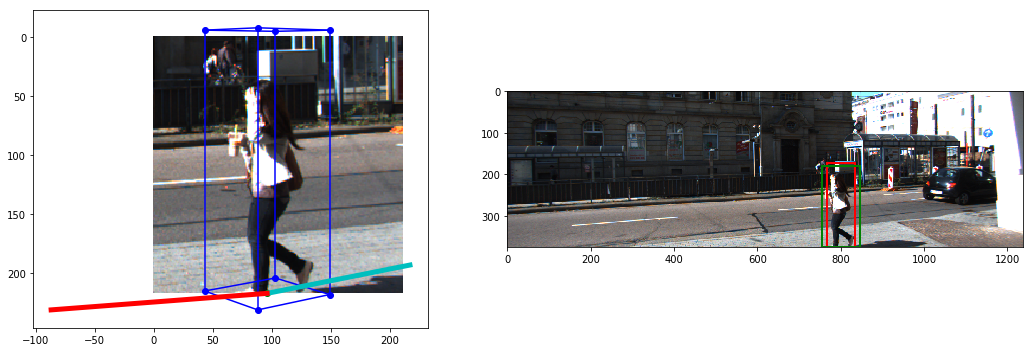

In [75]:
show_3d(ped)